# Exploring Speaker Voice Similarity Across British Accents Using WavLM
# - Part II

This Notebook continues the work of the [previous](https://github.com/BahneTP/Speaker-Voice-Similarity-Analysis/blob/main/EDA_and_Embedding_Extraction.ipynb) one, and is contains the following steps:

* Computing speaker similarity using cosine similarity.
* To determine an optimal similarity threshold that distinguishes between speakers accurately.
* To evaluate the system using quantitative metrics such as accuracy and confusion matrices.
* To explore embedding spaces using dimensionality reduction techniques like t-SNE or PCA for clustering analysis.

An extensive Report can be [accessed here](https://github.com/BahneTP/Speaker-Voice-Similarity-Analysis/blob/main/Bahne_Thiel_Peters_Exploring_Speaker_Voice_Similarity_Across_British_Accents_Using_WavLM.pdf).
First, let's load the dataframe we calculated in the previous notebook.

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/abi1_dataset_with_embeddings.csv')
df.head()

,accent,gender,narrator,file_name,duration_sec,accent_full,embedding
0,gla_001,female,lxd001,shortpassagec_CT.wav,39.371429,Glasgow,[-0.15204653 -0.10325734 -0.12303982 -0.004350...
1,gla_001,female,lxd001,shortpassageb_CT.wav,33.996916,Glasgow,[-0.1667784 -0.10688769 -0.13540581 -0.005317...
2,gla_001,female,lxd001,shortpassagea_CT.wav,34.121905,Glasgow,[-0.17256695 -0.12238953 -0.1473812 -0.009356...
3,gla_001,female,mad001,shortpassagec_CT.wav,43.246077,Glasgow,[-0.18117876 -0.12166425 -0.17096357 -0.143096...
4,gla_001,female,mad001,shortpassageb_CT.wav,39.121451,Glasgow,[-0.16928044 -0.11791914 -0.17018943 -0.167109...


To use the embeddings column, we need to add commas between the values.

In [ ]:
import numpy as np
def parse_embedding_string(s):
    s = s.strip()[1:-1]   # remove '[' and ']'
    parts = s.split()     # Split on whitespace
    # Convert each split token into float
    floats = [float(p) for p in parts]
    return np.array(floats)

df['embedding'] = df['embedding'].apply(parse_embedding_string)

# 4. Evaluation

# 4.2 Quantitative Metrics

This section focuses on determining the optimal similarity threshold. The threshold specifies the similarity value at which two embeddings are considered to belong to the same narrator. To achieve this, we calculate various metrics—accuracy, precision, recall, and F1-score—for each threshold value.

To experiment with different thresholds, we first calculate the cosine similarity scores between all embeddings. Next, we compute the metrics for each threshold and, finally, plot a graph to visualize all the scores.



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_matrix(df, label_column='narrator'):
    """
    Calculates the pairwise cosine similarity matrix and ground truth for speaker labels.

    Returns:
    - similarity_matrix (ndarray): Pairwise similarity matrix.
    - same_speaker_matrix (ndarray): Ground truth matrix for same/different speaker.
    """
    embeddings = np.array(df['embedding'].tolist())
    labels = df[label_column].values

    # Calculate pairwise similarities
    similarity_matrix = cosine_similarity(embeddings)
    same_speaker_matrix = np.equal.outer(labels, labels)

    return similarity_matrix, same_speaker_matrix

# Precompute similarity and ground truth matrices
similarity_matrix, same_speaker_matrix = calculate_similarity_matrix(df, label_column='narrator')

In [ ]:
def calculate_metrics_from_similarity(similarity_matrix, same_speaker_matrix, threshold):
    """
    Calculates performance metrics based on the similarity matrix and a threshold.

    Parameters:
    - similarity_matrix: Pairwise similarity matrix.
    - same_speaker_matrix: Ground truth matrix for speaker labels.
    - threshold: Cosine similarity threshold.

    Returns:
    - Accuracy, precision, recall, F1-score.
    """
    # Convert similarity matrix to binary predictions
    predictions = similarity_matrix > threshold

    # Flatten matrices for metric calculation
    same_speaker = same_speaker_matrix.flatten()
    predictions = predictions.flatten()

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(same_speaker, predictions, average='binary', zero_division=0)
    accuracy = accuracy_score(same_speaker, predictions)

    return accuracy, precision, recall, f1


# Experiment with thresholds
thresholds = list(np.arange(0.8, 0.96, 0.01)) + list(np.arange(0.951, 1, 0.001))
thresholds = [round(x, 3) for x in thresholds]
metrics = [calculate_metrics_from_similarity(similarity_matrix, same_speaker_matrix, t) for t in thresholds]

best Accuracy score: 0.9998768851954447
best f1-score: 0.9824492979719188


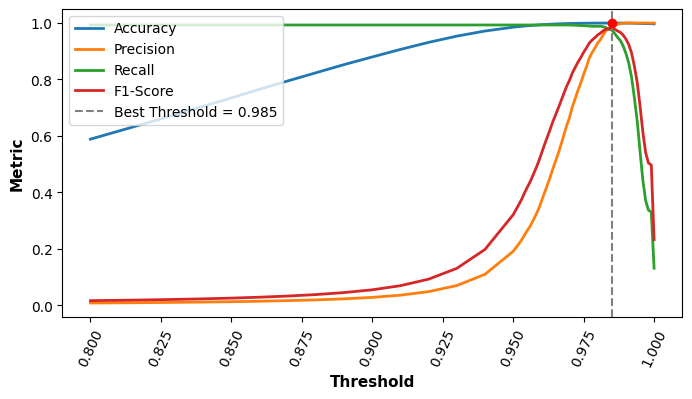

In [ ]:
import matplotlib.pyplot as plt

metrics = np.array(metrics)

# Get the index of the highest accuracy
max_accuracy_idx = np.argmax(metrics[:, 0])  # Accuracy is at index 0
max_accuracy = metrics[max_accuracy_idx, 0]
print(f'best Accuracy score: {max_accuracy}')
print(f'best f1-score: {metrics[np.argmax(metrics[:, 3]), 3]}')
best_threshold = thresholds[max_accuracy_idx]

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(8, 4))
plt.plot(thresholds, metrics[:, 0], label='Accuracy', color=cmap(0), linewidth=2)
plt.plot(thresholds, metrics[:, 1], label='Precision', color=cmap(1), linewidth=2)
plt.plot(thresholds, metrics[:, 2], label='Recall', color=cmap(2), linewidth=2)
plt.plot(thresholds, metrics[:, 3], label='F1-Score', color=cmap(3), linewidth=2)

# Add a dotted line for the highest accuracy.
plt.axvline(x=best_threshold, color='gray', linestyle='--', label=f'Best Threshold = {best_threshold:.3f}')
plt.scatter([best_threshold], [max_accuracy], color='red', zorder=5)  # Highlight the maximum accuracy point.
plt.xticks(rotation=65)
plt.xlabel('Threshold', fontweight='bold', fontsize=11)
plt.ylabel('Metric', fontweight='bold', fontsize=11)
plt.legend(loc='upper left')
plt.show()

At lower thresholds, **Precision** is very low because the model predicts "same" more liberally, resulting in many false positives.
At higher thresholds, **Recall** drops sharply because the model becomes overly strict, predicting "same" less often, resulting in more false negatives.

Overall, the best threshold is 0.985, resulting in the best f1-(0.982449) and accuracy score (0.999876).

### 4.1.1 Confusion Matrix

To better visualize the values at the best threshold, we plot a confusion matrix.

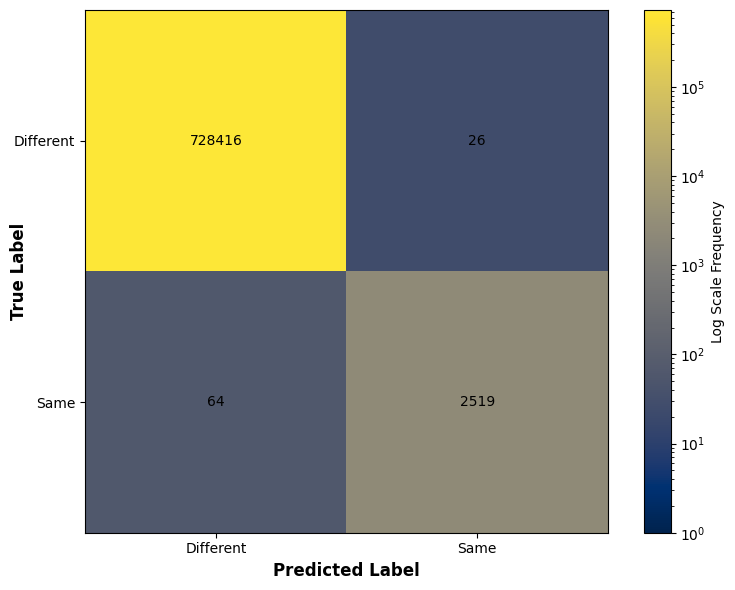

In [ ]:
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix

def compute_and_plot_confusion_matrix(similarity_matrix, threshold=best_threshold):
    """
    Computes and visualizes a confusion matrix based on the similarity threshold.

    Parameters:
    - similarity_matrix: Pairwise similarity matrix.
    - threshold: Cosine similarity threshold.
    """

    # Apply threshold to get predictions
    predictions = similarity_matrix > threshold

    # Flatten the matrices
    same_speaker = same_speaker_matrix.flatten()
    predictions = predictions.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(same_speaker, predictions)

    # Plot confusion matrix with plt.imshow
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='cividis', norm=LogNorm(vmin=1, vmax=cm.max()))
    plt.colorbar(label="Log Scale Frequency")
    plt.xlabel("Predicted Label", fontweight='bold', fontsize=12)
    plt.ylabel("True Label", fontweight='bold', labelpad = -10, fontsize=12)

    # Add annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center')

    # Set x and y ticks
    plt.xticks([0, 1], labels=["Different", "Same"])
    plt.yticks([0, 1], labels=["Different", "Same"])
    plt.tight_layout()
    plt.show()

compute_and_plot_confusion_matrix(similarity_matrix, threshold=best_threshold)


With 731,025 comparisons, the model misclassified only 90 cases. Of these, 64 were labeled "different" but were actually "same," indicating a slight bias toward predicting "different" when unsure. The confusion matrix shows 2,519 true positives and 728,416 true negatives, highlighting the model's high accuracy. The logarithmic scale emphasizes smaller counts, making errors visible despite the dominance of correct classifications.

# 4.1 Heatmap

### 4.1.1 Heatmap
To compare all embeddings, we use a heatmap that visualizes the degree of similarity through color.

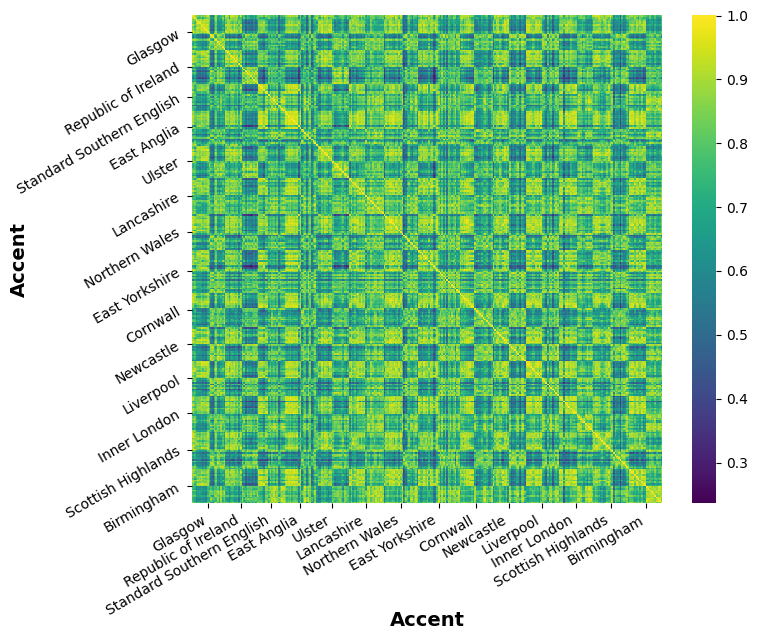

In [ ]:
import seaborn as sns
from matplotlib.colors import PowerNorm

def plot_embedding_heatmap(df, similarity_matrix):
    """
    Calculates and visualizes a heatmap of pairwise cosine similarities for embeddings, annotated with accents.
    Parameters:
    - df: DataFrame containing 'embedding' column and speaker labels.
    - similarity_matrix: Pairwise similarity matrix.
    """
    accents = df["accent_full"].tolist()

    # Group accents and calculate their midpoints, so the accents names poistions are aligned to the plot.
    unique_accents = []
    accent_midpoints = []
    start_idx = 0
    for i, accent in enumerate(accents):
        if i == len(accents) - 1 or accent != accents[i + 1]:
            unique_accents.append(accent)
            midpoint = (start_idx + i) / 2
            accent_midpoints.append(midpoint)
            start_idx = i + 1

    plt.figure(figsize=(8, 6.5))
    sns.heatmap(similarity_matrix,
                xticklabels=False,
                yticklabels=False,
                cmap='viridis',
                cbar=True)
    plt.xlabel("Accent", labelpad = -5, fontweight='bold', fontsize=14)
    plt.ylabel("Accent",labelpad = -10, fontweight='bold', fontsize=14)

    # Set accent labels at their midpoints
    plt.xticks(accent_midpoints, unique_accents, rotation=30, ha='right')
    plt.yticks(accent_midpoints, unique_accents, rotation=30)

    plt.tight_layout()
    plt.show()

# Example usage with a DataFrame containing 'embedding', 'narrator', and 'accent' columns
plot_embedding_heatmap(df, similarity_matrix)


The matrix is symmetric, reflecting the commutative nature of cosine similarity, with greenish areas highlighting moderate inter-accent similarities. The diagonal shows perfect similarity (1.0), as embeddings are compared to themselves. The plot is ordered by accents, with one square representing one gender of one accent. Within each accent, females come first, followed by males, meaning the upper line of squares shows similarities of female Glasgow speakers to all other accents, where odd squares represent females and even squares represent males.


*   Lancashire, East Yorkshire, and Birmingham male audios show relatively high similarity to female audios from other accents. This is evident in the second row of each respective accent and their odd-numbered columns.
*   East Anglia males stand out as having relatively many similarities with other accents.
*   Ulster shows the highest similarity to the Republic of Ireland for both genders, likely due to their geographical proximity.
*   Overall, there is a trend of lower similarity between male accents compared to the similarities among females.
*   Some samples stand out as significantly darker (blue) or brighter (green) compared to others in the heatmap. This likely indicates that these samples either have very low or very high similarity to most other embeddings. Such differences could arise from factors like a large age gap, which can impact vocal characteristics, or an atypical voice pitch that makes these samples acoustically distinct. These unique traits may result in embeddings that deviate from the general patterns observed in the dataset.

# 4.3 Analysis of a reduced Embedding Space

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap

def visualize_embeddings(df, label_col, num_samples=-1, show_legend=False, legend_size=10, perplexity=30, filter_by_male=False):
    """6
    Reduces the dimensionality of the embeddings and visualizes them in a 2D plot.
    - df: DataFrame containing 'embedding' column and speaker labels.
    - label_col: Name of the column in df, to group the samples by.
    - num_samples: How many samples to plot.
    - perplexity: The perplexity parameter for t-SNE, influencing how clusters are formed.
    - filter_by_male: If True, only male speakers will be plotted.
    """
    if filter_by_male:
        df = df[df['gender'] == 'male']
    embeddings = np.array(df['embedding'].tolist())[0:num_samples]
    labels = df[label_col].values
    print(len(set(labels[0:num_samples])))
    # Ensure embeddings and labels have matching sizes
    if embeddings.shape[0] != len(labels):
        min_size = min(embeddings.shape[0], len(labels))
        embeddings = embeddings[:min_size]
        labels = labels[:min_size]

    reducer = TSNE(n_components=2, perplexity=perplexity, random_state=27)
    reduced_embeddings = reducer.fit_transform(embeddings)

        # Use colormap
    cmap = get_cmap("tab20")
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)

    plt.figure(figsize=(8, 5))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        idx = (labels == label)
        plt.scatter(
            reduced_embeddings[idx, 0],
            reduced_embeddings[idx, 1],
            label=f"{label}",
            alpha=1,
            edgecolors="black",
            color=cmap(i / num_classes)  # Normalize color index to [0, 1]
        )
    plt.xlabel("tSNE 1", fontweight='bold', fontsize=12)
    plt.ylabel("tSNE 2", fontweight='bold', fontsize=12)
    if show_legend: plt.legend(loc='upper left', fontsize=legend_size) #upper left
    plt.tight_layout()
    plt.show()

2


<ipython-input-20-8006f9749bcd>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


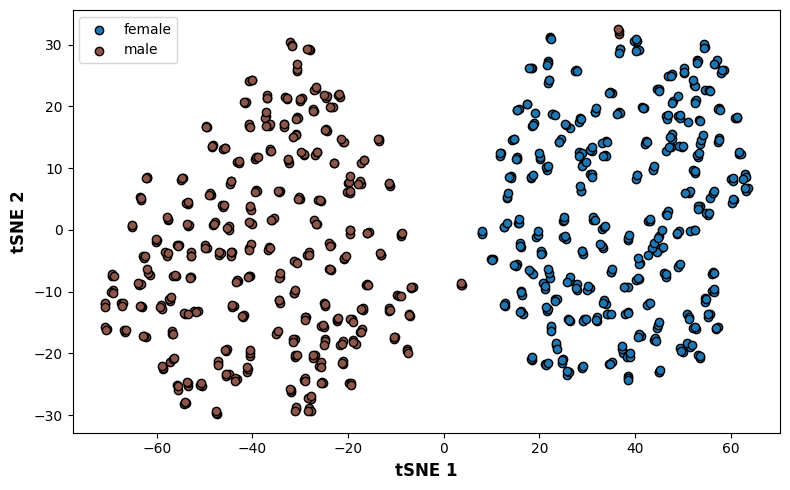

In [ ]:
#A plot visualizing the genders in another colour.
visualize_embeddings(df, "gender", -1, True, perplexity=20, filter_by_male=False)

This t-SNE visualization demonstrates embeddings grouped by gender: male and female. The plot shows clear separability between the two genders, with distinct clusters for male and female speakers. This indicates that the model captures gender-specific vocal characteristics, such as pitch and timbre, effectively. The lack of significant overlap between the two clusters highlights the model's robustness in differentiating between genders. However, since gender is a broad attribute, further analysis on speaker-level characteristics is needed to assess its precision for more granular tasks.

6


<ipython-input-20-8006f9749bcd>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


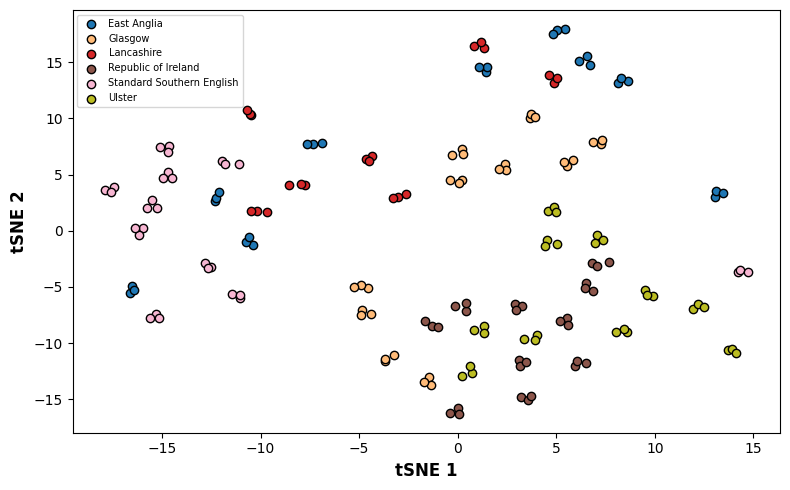

In [ ]:
#A plot visualizing each accent in another colour.
visualize_embeddings(df, "accent_full", 168, show_legend=True, legend_size=7, perplexity=20, filter_by_male = True)

To better distinguish the embeddings, this plot focuses only on male samples and includes six different accents.

*   Ulster and Republic of Ireland embeddings are highly intermixed, likely due to their geographical proximity (as discussed in the heatmap analysis).
*   East Anglia is widely spread across the plot, suggesting the accent may be more "general." This aligns with its high similarity to other accents observed in the heatmap.
*   Compared to the other accents, Standard Southern English embeddings are tightly clustered, indicating a more distinct and cohesive accent.

56


<ipython-input-20-8006f9749bcd>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


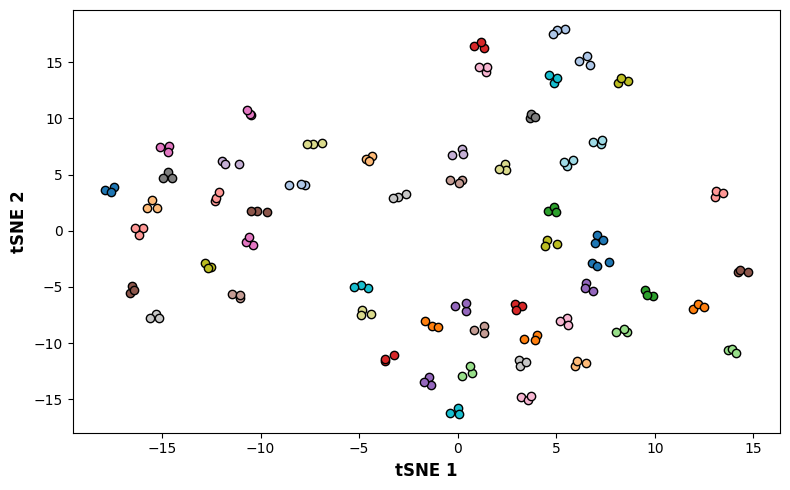

In [ ]:
#A plot visualizing each narrator in another colour.
visualize_embeddings(df, "narrator", 168, perplexity=20, filter_by_male=True)

This t-SNE visualization groups embeddings by 56 different narrators, each assigned a unique color. The plot demonstrates good clustering for individual narrators, with compact, non-overlapping clusters for most speakers. This suggests that the model accurately encodes speaker-specific characteristics, enabling clear differentiation between narrators.

# Discussion
-Age of speakers is not given. Since every accent has only 30 speaker per gender, there might be some unequality in age between the accents, causing difficulties in evaluating these.
-Is everyone saying the same think? look it up!

# 5. Going beyond/Future work


*   Fine Tuning. Maybe with another dataset? Is there Ab2?
*   Other similarity metric, maybe train an own.
*   
*   



